In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import networkx as nx
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

# NLTK 다운로드
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
df = pd.read_csv('/content/drive/MyDrive/특허/nn.csv', encoding='cp949')
print(df)

      출원인_연도 메인 IPC 전체 IPC Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  \
0       2024   H02S   H02S     030/20      [B63B     001/32       B63B   
1       2023   A62C   A62C     003/08      [B64D     033/00       B64D   
2       2023   B64U   B64U     010/14      [A62C     013/78       A62C   
3       2023   G06Q   G06Q     050/10      [A61L     002/20       A61L   
4       2023   A62C   A62C     003/02      [B64C     039/02       B64D   
...      ...    ...    ...        ...        ...        ...        ...   
4177    2014   A62B   A62B     003/00      [A62B     099/00       B64D   
4178    2014   B64D   B64D     045/00        NaN        NaN        NaN   
4179    2014   G01R   G01R     031/08      [B64D     027/08       B64D   
4180    2014   B64C   B64C     001/20      [B64D     011/00       A47B   
4181    2014   B64D   B64D     045/00      [G08G     005/00       G07C   

     Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 50 Unnamed: 51  \
0        025/00       B63H     020/00  ..

In [22]:
df = df.drop(['출원인_연도', '메인 IPC'], axis=1)
df['joined'] = df.apply(lambda row: ' '.join(row.astype(str)), axis=1)
print(df)

     전체 IPC Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8  \
0      H02S     030/20      [B63B     001/32       B63B     025/00       B63H   
1      A62C     003/08      [B64D     033/00       B64D    025/00]        NaN   
2      B64U     010/14      [A62C     013/78       A62C     003/02       A62C   
3      G06Q     050/10      [A61L     002/20       A61L    009/015       B01D   
4      A62C     003/02      [B64C     039/02       B64D     001/02       B64U   
...     ...        ...        ...        ...        ...        ...        ...   
4177   A62B     003/00      [A62B     099/00       B64D     011/00       B64D   
4178   B64D     045/00        NaN        NaN        NaN        NaN        NaN   
4179   G01R     031/08      [B64D     027/08       B64D     047/00       H02G   
4180   B64C     001/20      [B64D     011/00       A47B    046/00]        NaN   
4181   B64D     045/00      [G08G     005/00       G07C    005/00]        NaN   

     Unnamed: 9 Unnamed: 10

In [35]:
df3_clean = df.apply(lambda x: x.str.replace("[^a-zA-Z0-9]", " ", regex=True))
df4 = df3_clean.iloc[:,0::2]
df4 = df4.fillna(' ')
df4 = df4.astype(str)
df5 = df4.apply(lambda x: ' '.join(x),axis=1)
print(df5.shape)
print(df5)

(4182,)
0       H02S  B63B  B63B  B63H  B63H  B64U  B64U  B64U...
1       A62C  B64D  B64D                              ...
2       B64U  A62C  A62C  A62C  A62C  B05B  B64U  B64U...
3       G06Q  A61L  A61L  B01D  B64C  B64U  C02F  G06Q...
4       A62C  B64C  B64D  B64U  B64U                  ...
                              ...                        
4177    A62B  A62B  B64D  B64D                        ...
4178    B64D                                          ...
4179    G01R  B64D  B64D  H02G                        ...
4180    B64C  B64D  A47B                              ...
4181    B64D  G08G  G07C                              ...
Length: 4182, dtype: object


단어쌍 만들기 진행중: 100%|██████████| 4182/4182 [01:22<00:00, 50.61it/s]


     word1 word2    freq
0     b64c   nan  375750
1       00   nan  374571
2     b64d   nan  346806
3       02   nan  312084
4      001   nan  247572
...    ...   ...     ...
3450   007  b01d     100
3451    86  g01s     100
3452    77  h04n     100
3453  2021  h01m     100
3454  b60l  g05d     100

[3455 rows x 3 columns]


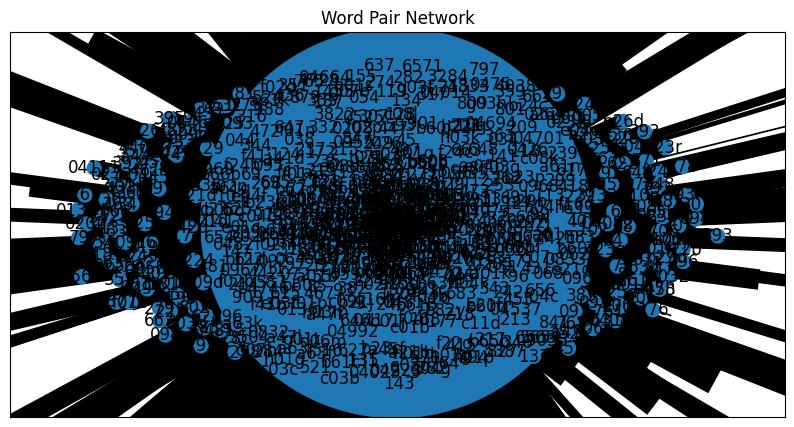

In [34]:
# def preprocessing(text):
#     if isinstance(text, float):
#         text = str(text)
#     text = text.lower()
#     text = re.sub(r"[^a-zA-Z]", " ", text)
#     tokens = word_tokenize(text)
#     stop_words = set(stopwords.words('english'))
#     stop_words.update(['claim', 'non'])
#     tokens = [item for item in tokens if item not in stop_words]
#     lemmatizer = WordNetLemmatizer()
#     lemmatized_tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
#     return ' '.join(lemmatized_tokens)

# # Apply preprocessing
# docs['독립항_en'] = docs['독립항_en'].apply(preprocessing)
# docs['text_en'] = docs['text_en'].apply(preprocessing)
# docs['발명의 명칭'] = docs['발명의 명칭'].apply(preprocessing)

# # Combine the text columns into one
# combined_docs = docs['독립항_en'] + " " + docs['text_en'] + " " + docs['발명의 명칭']
# docs['all'] = combined_docs

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df5)

# 문서-용어 행렬 생성
vect = CountVectorizer()
document_term_matrix = vect.fit_transform(df5)
column_list = vect.get_feature_names_out()

# 단어 쌍 빈도 계산
tf = pd.DataFrame(document_term_matrix.toarray(), columns=column_list)
count_dict = {}

for doc_number in tqdm(range(len(df5)), desc='단어쌍 만들기 진행중'):
    tmp = tf.loc[doc_number]
    for i, word1 in enumerate(column_list):
        if tmp[word1]:
            for j in range(i + 1, len(column_list)):
                if tmp[column_list[j]]:
                    count_dict[(column_list[i], column_list[j])] = count_dict.get((column_list[i], column_list[j]), 0) + max(tmp[word1], tmp[column_list[j]])

# 결과 데이터프레임 생성
count_list = [[words[0], words[1], count_dict[words]] for words in count_dict]
df_result = pd.DataFrame(count_list, columns=["word1", "word2", "freq"])
df_result = df_result.sort_values(by=['freq'], ascending=False).reset_index(drop=True)
df_result =  df_result[df_result['freq'] >= 100]
print(df_result)

# 네트워크 그래프 생성
G = nx.Graph()

for _, row in df_result.iterrows():
    G.add_edge(row['word1'], row['word2'], weight=row['freq'])

plt.figure(figsize=(10, 5))

node_size = [G.degree(node) * 100 for node in G.nodes()]
edge_width = [d['weight'] / 10 for (u, v, d) in G.edges(data=True)]
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx(G, pos, node_size=node_size, width=edge_width, with_labels=True, font_size=12)
plt.title('Word Pair Network')
plt.show()

nx.write_gexf(G,r"/content/drive/MyDrive/kk.gexf")

In [ ]:
# corpus = df[['0','2','4','6','8','10','12']]

In [ ]:
# vect = CountVectorizer()
# document_term_matrix = vect.fit_transform(corpus)
# dtm_dense = document_term_matrix.todense()
# dtm_dense

NameError: name 'corpus' is not defined

In [ ]:
# dtm_name = vect.get_feature_names_out(df)
# dtm_name

array(['10', '12'], dtype=object)

In [ ]:
# tf = pd.DataFrame(document_term_matrix.toarray(),
#                   columns=vect.get_feature_names_out())
# tf

,10,12
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,1,0
6,0,1


In [ ]:
# import pandas as pd
# from tqdm import tqdm
# from sklearn.feature_extraction.text import CountVectorizer
# import networkx as nx
# import matplotlib.pyplot as plt

# # CountVectorizer를 사용하여 문서-단어 행렬 생성
# vect = CountVectorizer()
# document_term_matrix = vect.fit_transform(corpus)

# # 데이터셋과 컬럼 리스트 설정
# dataset = df
# column_list = vect.get_feature_names_out()
# word_length = len(column_list)

# # 문서-단어 행렬을 데이터프레임으로 변환
# tf = pd.DataFrame(document_term_matrix.toarray(), columns=column_list)

# count_dict = {}

# # 단어 쌍의 빈도 계산
# for doc_number in tqdm(range(tf.shape[0]), desc='단어쌍 만들기 진행중'):
#     tmp = tf.loc[doc_number]
#     for i, word1 in enumerate(column_list):
#         if tmp[word1]:
#             for j in range(i + 1, word_length):
#                 if tmp[column_list[j]]:
#                     count_dict[(column_list[i], column_list[j])] = count_dict.get((column_list[i], column_list[j]), 0) + max(tmp[word1], tmp[column_list[j]])

# count_list = []

# # 단어 쌍과 빈도를 리스트로 변환
# for words in count_dict:
#     count_list.append([words[0], words[1], count_dict[words]])

# # 데이터프레임으로 변환 및 정렬
# df_result = pd.DataFrame(count_list, columns=["word1", "word2", "freq"])
# df_result = df_result.sort_values(by=['freq'], ascending=False)
# df_result = df_result.reset_index(drop=True)

# # 네트워크 그래프 생성
# G = nx.Graph()

# # 엣지 추가
# for _, row in df_result.iterrows():
#     G.add_edge(row['word1'], row['word2'], weight=row['freq'])

# # 네트워크 그래프 시각화
# plt.figure(figsize=(120, 120))

# # 노드의 크기를 빈도수에 따라 조정
# node_size = [G.degree(node) * 100 for node in G.nodes()]

# # 엣지의 굵기를 가중치에 따라 조정
# edge_width = [d['weight'] / 10 for (u, v, d) in G.edges(data=True)]

# pos = nx.spring_layout(G, k=0.1)

# nx.draw_networkx(G, pos, node_size=node_size, width=edge_width, with_labels=True, font_size=12)
# plt.title('Word Pair Network')
# plt.show()


In [ ]:
print(df_result)

Empty DataFrame
Columns: [word1, word2, freq]
Index: []


In [ ]:
nx.write_gexf(G,r"/content/drive/MyDrive/이게됨.gexf")